<div style="display: flex;">
    <h1 style="margin: auto; font-weight: bold; color: black; padding: 30px 30px 0px 30px;" align="center"> Projet 5 : 
Segmentez des clients d'un site e-commerce
 </h1>
</div>

<div style="display: flex; margin: auto; padding: 5px 30px 0px 30px;" > <h2 style="width: 100%; text-align: center; color: black; float: left;" align="center">Simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation.</h2> 
</div>

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">0. Importations librairies, fonctions, fichiers </h3>
</div>

In [29]:
# Importation des librairies
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
import os
import io
import re
import gc
import itertools
import math
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import plotly as pl
import plotly.express as px
from pandas import Timedelta
import functools
import scipy.stats as st
import statsmodels.api as sm
import pyarrow.parquet as pq
import time as time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime as dt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from math import prod
from time import time
from datetime import timedelta, date, datetime
from sklearn import metrics, cluster
from sklearn.preprocessing import FunctionTransformer
from collections import Counter
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, mean_squared_error,  r2_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.utils.validation import check_is_fitted
from statsmodels.graphics.gofplots import qqplot
%matplotlib inline
warnings.filterwarnings('ignore')
# %load_ext pycodestyle_magic
# %pycodestyle_on


In [30]:
df = pd.read_csv('pret_pour_simulation_rfm.csv')

In [31]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [32]:
print(df['order_purchase_timestamp'].max())
print(df['order_purchase_timestamp'].min())

2018-08-29 00:00:00
2016-10-03 00:00:00


In [33]:
df = df[['order_purchase_timestamp', 'recency', 'frequency', 'monetary']]
rfm = ['recency', 'frequency', 'monetary']

<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1. Premiers tests </h3>
</div>

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">a. Modèle initial M0 </h4>
</div>

In [34]:
# start_date = dt.datetime(2017, 1, 1, 0, 0)
# start_T0 = dt.datetime(2018, 1, 1, 0, 0)
# mask = (df['order_purchase_timestamp'] > start_date) & (df['order_purchase_timestamp'] <= start_T0)
# F0 = df.loc[mask].drop(columns='order_purchase_timestamp')
# preprocessor = ColumnTransformer([('scaler', MinMaxScaler(), F0.columns)])
# Km = KMeans(n_clusters=5, n_init=1, init='k-means++', max_iter=400, random_state=1)
# Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])
# M0 = Km_pipe.fit(F0)


<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">b. Modèle M1 </h4>
</div>

In [35]:
# period_days = 5
# start_date = dt.datetime(2017, 1, 1, 0, 0)
# start_T0 = dt.datetime(2018, 1, 1, 0, 0)
# start_date_T1 = start_T0 + timedelta(days=period_days)
# mask = (df['order_purchase_timestamp'] > start_date) & (df['order_purchase_timestamp'] <= start_date_T1)
# F1 = df.loc[mask].drop(columns='order_purchase_timestamp')
# preprocessor = ColumnTransformer([('scaler', MinMaxScaler(), F1.columns)])
# Km = KMeans(n_clusters= 5, n_init=1, init='k-means++', max_iter= 400, random_state=1)
# Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])
# M1 = Km_pipe.fit(F1)
# C1_init = M0.predict(F1)
# C1_pred = M1.predict(F1)
# ari_pred_T1 = adjusted_rand_score(C1_init, C1_pred)
# ari_pred_T1

<div style="background-color: black;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">c. Modèle M2 </h4>
</div>

In [36]:
# period_days = 10
# start_date = dt.datetime(2017, 1, 1, 0, 0)
# start_T0 = dt.datetime(2018, 1, 1, 0, 0)
# start_date_T2 = start_T0 + timedelta(days=period_days)
# mask = (df['order_purchase_timestamp'] > start_date) & (df['order_purchase_timestamp'] <= start_date_T2)
# F2 = df.loc[mask].drop(columns='order_purchase_timestamp')
# preprocessor = ColumnTransformer([('scaler', MinMaxScaler(), F2.columns)])
# Km = KMeans(n_clusters= 5, n_init=1, init='k-means++', max_iter= 400, random_state=1)
# Km_pipe = Pipeline([("preprocessor", preprocessor), ("kmeans", Km)])
# M2 = Km_pipe.fit(F2)
# C2_init = M0.predict(F2)
# C2_pred = M2.predict(F2)
# ari_pred_T2 = adjusted_rand_score(C2_init, C2_pred)
# ari_pred_T2


<div style="background-color: black;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2. Fonction d'evaluation de la stabilité dans le temps  </h3>
</div>

In [37]:
# Periode initiale
start_date = dt.datetime(2017, 1, 1, 0, 0)
start_T0 = dt.datetime(2018, 1, 1, 0, 0)
mask_F0 = (df['order_purchase_timestamp'] > start_date) & (
    df['order_purchase_timestamp'] <= start_T0)
data_init = df.loc[mask_F0].drop(columns='order_purchase_timestamp')

# Kmean sur la période initiale
kmeans_init = Pipeline([("preprocessor", MinMaxScaler()),
                        ("kmeans", KMeans(n_clusters=5, n_init=1, init='k-means++', max_iter=400, random_state=1))])
kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_

In [38]:
ari_score = []

for p in range(1, 30):
    # Création des datasets par périodes
    start_date = dt.datetime(2017, 1, 1, 0, 0)
    start_T0 = dt.datetime(2018, 1, 1, 0, 0)
    start_date_Tp = start_T0 + timedelta(days=p)
    data_period = df.copy()
    mask_data_period = (df['order_purchase_timestamp'] > start_date) & (
        df['order_purchase_timestamp'] <= start_date_Tp)
    data_period = df.loc[mask_data_period].drop(
        columns='order_purchase_timestamp')
    preprocessor = ColumnTransformer(
        [('scaler', MinMaxScaler(), data_period.columns)])

    # K-Means
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(n_clusters=5, n_init=1, init='k-means++', max_iter=400, random_state=1))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_

    # Calcul des ARI score
    ari_p = adjusted_rand_score(kmeans_init.predict(
        data_period), kmeans_p.predict(data_period))
    ari_score.append([p, ari_p])


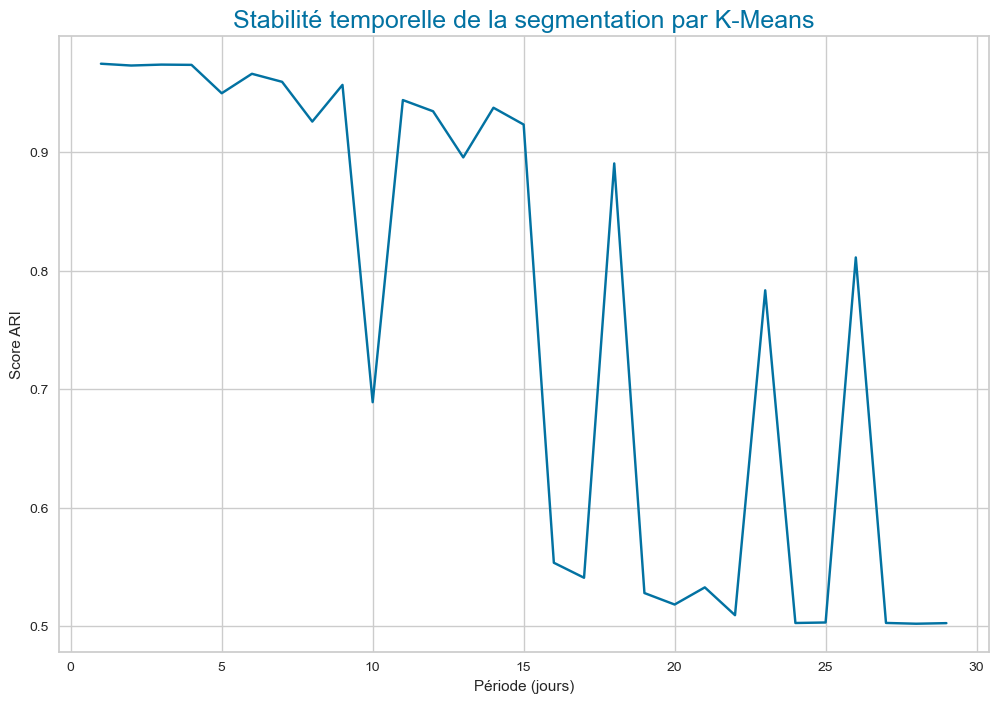

In [39]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.xlabel("Période (jours)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

In [40]:
# Réentrainement date de début T0 la plus proche possible de la date de fin du fichier (août 2018)
# start_date = dt.datetime(2018, 8, 19, 0, 0)
# start_T0 = dt.datetime(2018, 8, 29, 0, 0)
# mask_F0 = (df['order_purchase_timestamp'] > start_date) & (
#     df['order_purchase_timestamp'] <= start_T0)
# data_init = df.loc[mask_F0].drop(columns='order_purchase_timestamp')

# # Kmean sur la période initiale
# kmeans_init = Pipeline([("preprocessor", MinMaxScaler()),
#                         ("kmeans", KMeans(n_clusters=5, n_init=1, init='k-means++', max_iter=400, random_state=1))])
# kmeans_init.fit(data_init)
# init_labels = kmeans_init.named_steps['kmeans'].labels_
